# Introduction & Setup

Protein Structure Prediction is an important task in bioinformatics. Proteins are essential molecules in living organisms, and their function is determined by how they fold into 3D structures. The secondary structure prediction task involves predicting the local structure elements of a protein (such as helices, strands, and loops) based on the amino acid sequence.

Traditionally, these structures are determined using experimental techniques such as X-ray crystallography or NMR, which are expensive and time-consuming. Deep learning models like Convolutional Neural Networks (CNNs) offer a faster, computational approach to predict these secondary structures (sst3 and sst8) from the primary sequences of amino acids.

The goal of this project is to predict two levels of secondary structure from protein sequences:
1. **sst3**: Three-state secondary structure classification (helix, strand, coil).
2. **sst8**: Eight-state secondary structure classification for more granularity.

We will be focusing on CNNs as our deep learning approach to achieve this prediction.


#### Installation and Imports

In [ ]:
pip install bayesian-optimization

In [ ]:
import pandas as pd
import numpy as np
import time
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import os
import random
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/Neural Networks Project/alfrandom/2018-06-06-pdb-intersect-pisces.csv"
df = pd.read_csv(file_path)

In [ ]:
# Define the output directory on Google Drive
output_dir = '/content/drive/My Drive/Neural Networks Project/CNN_Equipair_Updated'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [ ]:
# Test Set
test_size = 100
test_ix = random.sample(range(df.shape[0]), test_size)
df_test = df.iloc[test_ix].reset_index(drop=True)
df = df.drop(test_ix).reset_index(drop=True)
print(f"Training Set Shape: {df.shape}")
print(f"Test Set Shape: {df_test.shape}")


Training Set Shape: (8978, 11)
Test Set Shape: (100, 11)


# Preprocessing

## Padding & Cropping

In [ ]:
# Preprocessing Functions

def pad_sequence(seq_df, maxlen):
    """Pads sequences with dots and adds delimiters."""
    out = ['<'+i+'>'+'.'*(maxlen-len(i)) for i in seq_df]
    return out

def crop_sequence(seq_long, max_len):
    """Breaks long sequences into subsequences of desired length."""
    # Cracking Sequence
    out_1 = [
        '<' + seq_long[j][i-max_len:i] + '.' if i == 0
        else '.' + seq_long[j][i-max_len:i] + '.'
        for j in seq_long.index
        for i in range(max_len, len(seq_long[j]), max_len)
    ]
    # Extracting and padding the last part of each sequence
    out_2 = [
        seq_long[j][max_len * (len(seq_long[j]) // max_len):]
        for j in seq_long.index
    ]
    out_2 = pad_sequence(out_2, max_len)
    # Unifying both
    out_1.extend(out_2)
    return out_1

def crop_pad_sequences(df, max_len):
    """Pads or crops sequences based on their lengths."""
    # Dividing Dataset
    df_short = df[df['seq'].str.len() < max_len]  # Needs padding
    df_exact = df[df['seq'].str.len() == max_len]  # Exact length
    df_long = df[df['seq'].str.len() > max_len]  # Needs cropping

    # Preparing Features
    seq_short = pad_sequence(df_short['seq'], max_len)
    seq_exact = ['<'+i+'>' for i in df_exact['seq']]
    seq_long = crop_sequence(df_long['seq'], max_len)
    seq_features = [i for l in [seq_short, seq_exact, seq_long] for i in l]  # Concatenation
    print(f'Number of Sequences: {len(seq_features)}')

    # Preparing Q3
    q3_short = pad_sequence(df_short['sst3'], max_len)
    q3_exact = ['<'+i+'>' for i in df_exact['sst3']]
    q3_long = crop_sequence(df_long['sst3'], max_len)
    q3 = [i for l in [q3_short, q3_exact, q3_long] for i in l]
    print(f'Number of Q3 Labels: {len(q3)}')

    # Preparing Q8
    q8_short = pad_sequence(df_short['sst8'], max_len)
    q8_exact = ['<'+i+'>' for i in df_exact['sst8']]
    q8_long = crop_sequence(df_long['sst8'], max_len)
    q8 = [i for l in [q8_short, q8_exact, q8_long] for i in l]
    print(f'Number of Q8 Labels: {len(q8)}')

    # Checking Sequence Lengths
    for label, data_list in zip(['Q8', 'Q3', 'Sequences'], [q8, q3, seq_features]):
        lens = [len(j) for j in data_list]
        incorrect = [j for j in lens if j != max_len+2]
        print(f'{label} without desired length ({max_len+2}): {len(incorrect)}')

    return seq_features, q3, q8


In [ ]:
# Assuming you have a DataFrame `df` and `df_test`

# Sequence Standardization
max_len = int(np.mean(df['len']))  # Hyperparameter: mean sequence length
print(f'Maximum Sequence Length (mean): {max_len}')



Maximum Sequence Length (mean): 243


## Encoders, Decoders & Vocabs

In [ ]:

# Apply Padding and Cropping
seq_features, q3, q8 = crop_pad_sequences(df, max_len)

# Encoding Functions

def enc_dec_vocab(sequence):
    """Creates encoder and decoder functions along with vocab mappings."""
    seq_vocab = np.unique([j for i in sequence for j in i])  # Vocab Dictionary
    seq_stoi = {str(j): i for i, j in enumerate(seq_vocab)}  # String-to-Index
    seq_itos = {i: str(j) for i, j in enumerate(seq_vocab)}  # Index-to-String
    seq_encoder = lambda s: [seq_stoi[c] for c in s]  # Encoder Function
    seq_decoder = lambda s: [seq_itos[c] for c in s]  # Decoder Function
    print(f'Sequence vocabulary: {seq_vocab} | Vocab Length: {len(seq_vocab)}\n')

    return seq_encoder, seq_decoder, seq_vocab, seq_stoi, seq_itos


Number of Sequences: 13479
Number of Q3 Labels: 13479
Number of Q8 Labels: 13479
Q8 without desired length (245): 0
Q3 without desired length (245): 0
Sequences without desired length (245): 0


In [ ]:
# Features
seq_encoder , seq_decoder , seq_vocab, seq_stoi, seq_itos = enc_dec_vocab(seq_features)
# Q3
q3_encoder , q3_decoder , q3_vocab, q3_stoi, q3_itos = enc_dec_vocab(q3)
# Q8
q8_encoder , q8_decoder , q8_vocab, q8_stoi, q8_itos = enc_dec_vocab(q8)

Sequence vocabulary: ['*' '.' '<' '>' 'A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q'
 'R' 'S' 'T' 'V' 'W' 'Y'] | Vocab Length: 24

Sequence vocabulary: ['.' '<' '>' 'C' 'E' 'H'] | Vocab Length: 6

Sequence vocabulary: ['.' '<' '>' 'B' 'C' 'E' 'G' 'H' 'I' 'S' 'T'] | Vocab Length: 11



### Equipair Tokenization


In [ ]:
# Merge and Pad Functions

def merge(top_pair, ids, sequence, stoi, itos, dec):
    """Merges a given bigram into a single token for the whole dataset."""
    top_chars = dec(top_pair)
    merged_token = tuple(top_chars)
    if merged_token not in stoi:
        stoi[merged_token] = ids
        itos[ids] = merged_token
        new_id = ids
        ids += 1
    else:
        new_id = stoi[merged_token]
    newids = []  # New tokens list
    for tokens in sequence:
        i = 0
        newids_seq = []
        while i < len(tokens):  # While loop to iterate until all the list has been seen
            if i < len(tokens) - 1 and tokens[i] == top_pair[0] and tokens[i+1] == top_pair[1]:
                # Add to the new tokens the ids and skip the following element
                newids_seq.append(new_id)
                i += 2
            else:
                # Else, keep the token and continue
                newids_seq.append(tokens[i])
                i += 1
        newids.append(newids_seq)
    return newids, ids

def pad_input(sequence, max_len):
    """Pads sequences with 0s until they reach the desired length."""
    for s in sequence:
        s.extend([0] * (max_len + 2 - len(s)))  # Adjusted to pad to max_len + 2
    return sequence

# Equipair Tokenization for Q3

# Encode Q3 sequences
q3s = [q3_encoder(seq) for seq in q3]

# Define pairs to merge for Equipair Tokenization
pairs_to_merge_q3 = [token + token for token in q3_vocab if token not in ['.', '<', '>']]

# Encode the pairs to merge
q3_pairs_to_merge = [q3_encoder(pair) for pair in pairs_to_merge_q3]

# Merge the pairs in Q3 sequences
ids = len(q3_stoi)
for e in q3_pairs_to_merge:
    q3s, ids = merge(e, ids, q3s, q3_stoi, q3_itos, q3_decoder)

# Pad the Q3 sequences
q3s = pad_input(q3s, max_len)

# Update Q3 vocabulary size
q3_vocab_size = len(q3_stoi)
print(f"Updated Q3 Vocabulary Size: {q3_vocab_size}")

# Equipair Tokenization for Q8

# Encode Q8 sequences
q8s = [q8_encoder(seq) for seq in q8]

# Define pairs to merge for Equipair Tokenization
q8_tokens = [token for token in q8_vocab if token not in ['.', '<', '>']]
pairs_to_merge_q8 = [token + token for token in q8_tokens]

# Encode the pairs to merge
q8_pairs_to_merge = [q8_encoder(pair) for pair in pairs_to_merge_q8]

# Merge the pairs in Q8 sequences
ids = len(q8_stoi)
for e in q8_pairs_to_merge:
    q8s, ids = merge(e, ids, q8s, q8_stoi, q8_itos, q8_decoder)

# Pad the Q8 sequences
q8s = pad_input(q8s, max_len)

# Update Q8 vocabulary size
q8_vocab_size = len(q8_stoi)
print(f"Updated Q8 Vocabulary Size: {q8_vocab_size}")

# Encode and pad sequences (No Equipair Tokenization for sequences)
seqs = [seq_encoder(seq) for seq in seq_features]
seqs = pad_input(seqs, max_len)


Updated Q3 Vocabulary Size: 9
Updated Q8 Vocabulary Size: 19


## Datasets & Dataloaders

In [ ]:
# Convert sequences to numpy arrays
seqs = np.array(seqs)
q3s = np.array(q3s)
q8s = np.array(q8s)

# Torchification: Convert to Tensors

X = torch.tensor(seqs, dtype=torch.long, device=device)
Y_q3 = torch.tensor(q3s, dtype=torch.long, device=device)
Y_q8 = torch.tensor(q8s, dtype=torch.long, device=device)

data_dict = {'X': X, 'Y_q3': Y_q3, 'Y_q8': Y_q8}
torch.save(data_dict, 'equipair_data_dictionary.pt')
torch.save(data_dict, os.path.join(output_dir, 'equipair_data_dictionary.pt'))

print(f'X shape: {X.shape} | Y_q3 shape: {Y_q3.shape} | Y_q8 shape: {Y_q8.shape}')

X shape: torch.Size([13479, 245]) | Y_q3 shape: torch.Size([13479, 245]) | Y_q8 shape: torch.Size([13479, 245])


In [ ]:
# Custom Dataset & DataLoader

class CustomDataset(Dataset):
    """Custom Dataset for sequence and label tensors."""
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def initialise_loaders(X_train, y_train, X_val, y_val, batch_size):
    """Creates DataLoaders for training and validation datasets."""
    train_dataset = CustomDataset(X=X_train, y=y_train)
    val_dataset = CustomDataset(X=X_val, y=y_val)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader


# Models

## CNN


In [ ]:
# Hyperparameters
batch_size = 256
context_size = max_len + 2
max_iters = 25  # Number of training epochs
eval_interval = 1  # Evaluate every 'eval_interval' epochs
lr = 3e-3
n_emb = 64
vocab_size = len(seq_vocab)
dropout = 0
patience = 5
md = 0.05
fact = 0.1
b1 = 0.9
b2 = 0.999

# CNN-specific hyperparameters
num_filters = 128
kernel_size = 5
num_conv_layers = 3

# Note: q3_vocab_size and q8_vocab_size have been updated after merging
print(f"Updated Q3 Vocabulary Size: {q3_vocab_size}")
print(f"Updated Q8 Vocabulary Size: {q8_vocab_size}")

Updated Q3 Vocabulary Size: 9
Updated Q8 Vocabulary Size: 19


In [ ]:

# CNN Model Definition

class ProteinCNN(nn.Module):
    def __init__(self, vs, n_emb, num_filters, kernel_size, num_conv_layers, dropout):
        super(ProteinCNN, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_emb, device=device)
        self.dropout = nn.Dropout(dropout)

        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            in_channels = n_emb if i == 0 else num_filters
            self.conv_layers.append(
                nn.Conv1d(in_channels, num_filters, kernel_size, padding=kernel_size // 2)
            )
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.Dropout(dropout))

        self.fc = nn.Linear(num_filters, vs, device=device)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.token_embedding(x)  # (batch_size, seq_len, n_emb)
        x = x.transpose(1, 2)        # (batch_size, n_emb, seq_len)
        x = self.dropout(x)
        for layer in self.conv_layers:
            x = layer(x)             # (batch_size, num_filters, seq_len)
        x = x.transpose(1, 2)        # (batch_size, seq_len, num_filters)
        logits = self.fc(x)          # (batch_size, seq_len, vs)
        return logits

# Early Stopping Class

class EarlyStopper:
    """Early stops the training if validation F1 doesn't improve after a given patience."""
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None

    def early_stop(self, score):
        if self.best_score is None:
            self.best_score = score
            return False
        elif score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

In [ ]:
# Training Class

class Training:
    def __init__(self, data, model, hyperparams, vocab_dict, verbose=False):
        self.train_loader, self.val_loader = initialise_loaders(
            data['x_train'], data['y_train'],
            data['x_val'], data['y_val'], hyperparams['batch_size']
        )
        self.model = model
        self.optimizer = torch.optim.AdamW(
            model.parameters(), lr=hyperparams['lr'], betas=(hyperparams['b1'], hyperparams['b2'])
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience']
        )
        self.hist_loss = {'train': [], 'val': []}
        self.hist_acc = {'train': [], 'val': []}
        self.hist_pres = {'train': [], 'val': []}
        self.hist_f1 = {'train': [], 'val': []}
        self.times = []
        self.hyper = hyperparams
        self.vocab = vocab_dict

        # Retrieve indices for tokens to ignore
        self.padding_index = vocab_dict.get('.', -1)
        self.start_index = vocab_dict.get('<', -1)
        self.end_index = vocab_dict.get('>', -1)
        self.ignore_index = -100
        self.indices_to_ignore = [self.padding_index, self.start_index, self.end_index]

        # Initialize loss function
        self.loss_func = nn.CrossEntropyLoss(ignore_index=self.ignore_index)

        self.early = EarlyStopper(patience=self.hyper['patience'], min_delta=self.hyper['min_delta'])
        self.verbose = verbose

    def __call__(self, *args, **kwargs):
        for epoch in range(self.hyper['epochs']):
            start_time = time.time()
            train_loss = 0
            train_acc = 0
            all_preds = []
            all_targets = []

            # Training Phase
            self.model.train()
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                logits = self.model(inputs)
                B, T, C = logits.shape
                logits_flat = logits.view(B * T, C)
                targets_flat = targets.view(B * T)

                # Create mask for valid positions
                mask = torch.ones_like(targets_flat, dtype=torch.bool)
                for idx in self.indices_to_ignore:
                    mask &= (targets_flat != idx)

                # Prepare targets for loss computation
                targets_for_loss = targets_flat.clone()
                targets_for_loss[~mask] = self.ignore_index

                # Compute loss
                loss = self.loss_func(logits_flat, targets_for_loss)
                train_loss += loss.item()

                # Compute accuracy only over valid positions
                preds = torch.argmax(logits_flat, dim=1)
                acc = (preds == targets_flat).float()
                acc = acc[mask].mean()
                train_acc += acc.item()

                # Collect predictions and targets for metric calculations
                all_preds.extend(preds[mask].cpu().numpy())
                all_targets.extend(targets_flat[mask].cpu().numpy())

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Logging Training Metrics
            avg_train_loss = train_loss / len(self.train_loader)
            avg_train_acc = train_acc / len(self.train_loader)
            self.hist_loss['train'].append(avg_train_loss)
            self.hist_acc['train'].append(avg_train_acc)
            self.hist_pres['train'].append(
                precision_score(all_targets, all_preds, average='weighted', zero_division=1)
            )
            self.hist_f1['train'].append(
                f1_score(all_targets, all_preds, average='weighted', zero_division=1)
            )

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.hyper['epochs']} | "
                      f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
                      f"Train Precision: {self.hist_pres['train'][-1]:.4f} | "
                      f"Train F1: {self.hist_f1['train'][-1]:.4f}")

            # Validation Phase
            if (epoch + 1) % self.hyper['eval_int'] == 0:
                val_loss, val_acc, val_precision, val_recall, val_f1 = self.evaluate()

                # Logging Validation Metrics
                self.hist_loss['val'].append(val_loss)
                self.hist_acc['val'].append(val_acc)
                self.hist_pres['val'].append(val_precision)
                self.hist_f1['val'].append(val_f1)

                if self.verbose:
                    print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f} | "
                          f"Validation Precision: {val_precision:.4f} | Validation F1: {val_f1:.4f}")

                # Early Stopping and Scheduler Step
                if self.early.early_stop(1 / val_f1):
                    if self.verbose:
                        print("Early stopping triggered.")
                    break
                self.scheduler.step(1 / val_f1)

            epoch_time = time.time() - start_time
            self.times.append(epoch_time)

    def evaluate(self):
        """Evaluates the model on the validation set."""
        self.model.eval()
        val_loss = 0
        val_acc = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                logits = self.model(inputs)
                B, T, C = logits.shape
                logits_flat = logits.view(B * T, C)
                targets_flat = targets.view(B * T)

                # Create mask for valid positions
                mask = torch.ones_like(targets_flat, dtype=torch.bool)
                for idx in self.indices_to_ignore:
                    mask &= (targets_flat != idx)

                # Prepare targets for loss computation
                targets_for_loss = targets_flat.clone()
                targets_for_loss[~mask] = self.ignore_index

                # Compute loss
                loss = self.loss_func(logits_flat, targets_for_loss)
                val_loss += loss.item()

                # Compute accuracy only over valid positions
                preds = torch.argmax(logits_flat, dim=1)
                acc = (preds == targets_flat).float()
                acc = acc[mask].mean()
                val_acc += acc.item()

                # Collect predictions and targets for metric calculations
                all_preds.extend(preds[mask].cpu().numpy())
                all_targets.extend(targets_flat[mask].cpu().numpy())

        # Calculate average metrics
        average_loss = val_loss / len(self.val_loader)
        average_acc = val_acc / len(self.val_loader)
        average_precision = precision_score(all_targets, all_preds, average='weighted', zero_division=1)
        average_recall = recall_score(all_targets, all_preds, average='weighted', zero_division=1)
        average_f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=1)

        return average_loss, average_acc, average_precision, average_recall, average_f1

In [ ]:
# Plot Learning Curves
def plot_learning_curves(tr, filename_prefix):
    plt.figure(figsize=(8, 5))
    plt.plot(tr.hist_loss['train'], label='Training Loss')
    plt.plot(tr.hist_loss['val'], label='Validation Loss')
    plt.title('Learning Curves - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(output_dir, f'{filename_prefix}_learning_curve_loss.png'))
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(tr.hist_acc['train'], label='Training Accuracy')
    plt.plot(tr.hist_acc['val'], label='Validation Accuracy')
    plt.title('Learning Curves - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(output_dir, f'{filename_prefix}_learning_curve_accuracy.png'))
    plt.show()

# Adjusted decoder functions to handle tuples
def adjusted_decoder(s, itos):
    decoded = []
    for c in s:
        val = itos[c]
        if isinstance(val, tuple):
            decoded.extend(val)
        else:
            decoded.append(val)
    return decoded

# Plot Confusion Matrix

def plot_confusion_matrix(model, tr, itos, stoi, title='Confusion Matrix', filename=None):
    model.eval()

    # Initialize lists to store all predictions and labels
    all_preds = []
    all_labels = []

    # Retrieve indices for tokens to ignore
    padding_index = stoi.get('.', -1)
    start_index = stoi.get('<', -1)
    end_index = stoi.get('>', -1)
    ignore_index = -100
    indices_to_ignore = [padding_index, start_index, end_index]

    with torch.no_grad():
        for batch, (X_i, y_i) in enumerate(tr.val_loader):
            logits = model(X_i)
            preds = torch.argmax(logits, dim=-1)

            # Flatten predictions and labels
            preds_flat = preds.reshape(-1)
            y_flat = y_i.reshape(-1)

            # Create a mask to exclude unwanted tokens
            mask = torch.ones_like(y_flat, dtype=torch.bool)
            for idx in indices_to_ignore:
                mask &= (y_flat != idx)

            # Apply mask and move tensors to CPU
            preds_flat = preds_flat[mask].cpu()
            y_flat = y_flat[mask].cpu()

            # Append to the lists
            all_preds.append(preds_flat)
            all_labels.append(y_flat)

    # Concatenate all predictions and labels
    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)

    # Convert to numpy arrays
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    # Generate confusion matrix
    valid_labels = sorted(set(y_true) | set(y_pred))
    print(f"Valid labels after filtering: {valid_labels}")

    # Adjust labels for display
    xticklabels = []
    for label in valid_labels:
        val = itos[label]
        if isinstance(val, tuple):
            xticklabels.append(''.join(val))
        else:
            xticklabels.append(val)

    cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=xticklabels,
                yticklabels=xticklabels)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    if filename:
        plt.savefig(os.path.join(output_dir, filename))
    plt.show()


## Initial Predictions

#### Q3

Q3 Model's trainable parameters: 207881
Epoch 1/25 | Train Loss: 1.5939 | Train Acc: 0.3206 | Train Precision: 0.2548 | Train F1: 0.2704
Validation Loss: 1.5065 | Validation Acc: 0.3526 | Validation Precision: 0.7718 | Validation F1: 0.1837
Epoch 2/25 | Train Loss: 1.4980 | Train Acc: 0.3573 | Train Precision: 0.5780 | Train F1: 0.2702
Validation Loss: 1.4931 | Validation Acc: 0.3598 | Validation Precision: 0.5813 | Validation F1: 0.2642
Epoch 3/25 | Train Loss: 1.4911 | Train Acc: 0.3611 | Train Precision: 0.5807 | Train F1: 0.2809
Validation Loss: 1.4913 | Validation Acc: 0.3572 | Validation Precision: 0.5808 | Validation F1: 0.2824
Epoch 4/25 | Train Loss: 1.4879 | Train Acc: 0.3656 | Train Precision: 0.5839 | Train F1: 0.2863
Validation Loss: 1.4879 | Validation Acc: 0.3642 | Validation Precision: 0.5833 | Validation F1: 0.2822
Epoch 5/25 | Train Loss: 1.4862 | Train Acc: 0.3679 | Train Precision: 0.5857 | Train F1: 0.2884
Validation Loss: 1.4870 | Validation Acc: 0.3653 | Validati

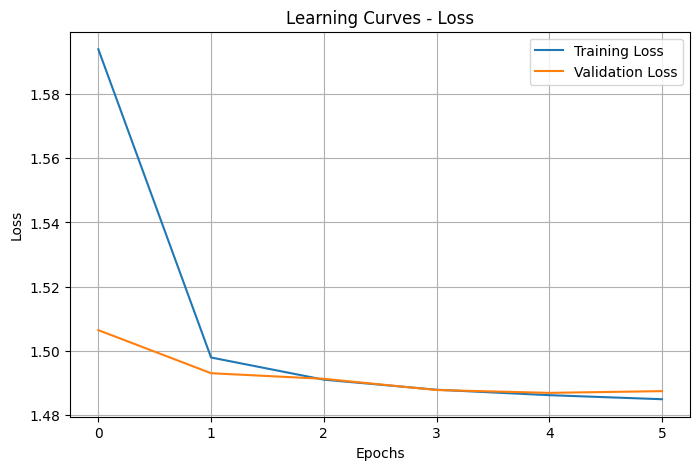

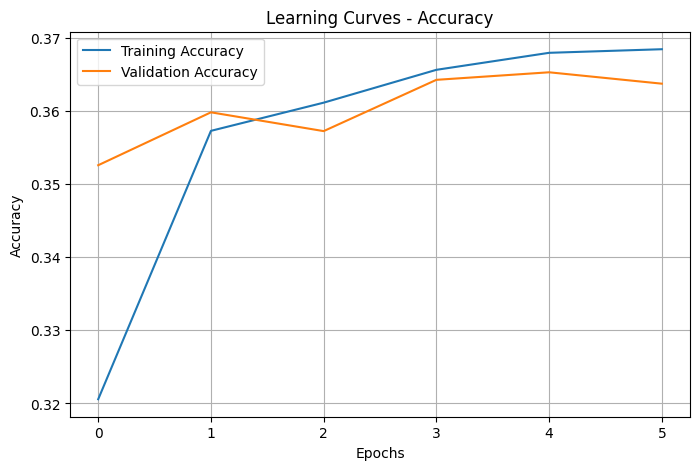

Valid labels after filtering: [3, 4, 5, 6, 7, 8]


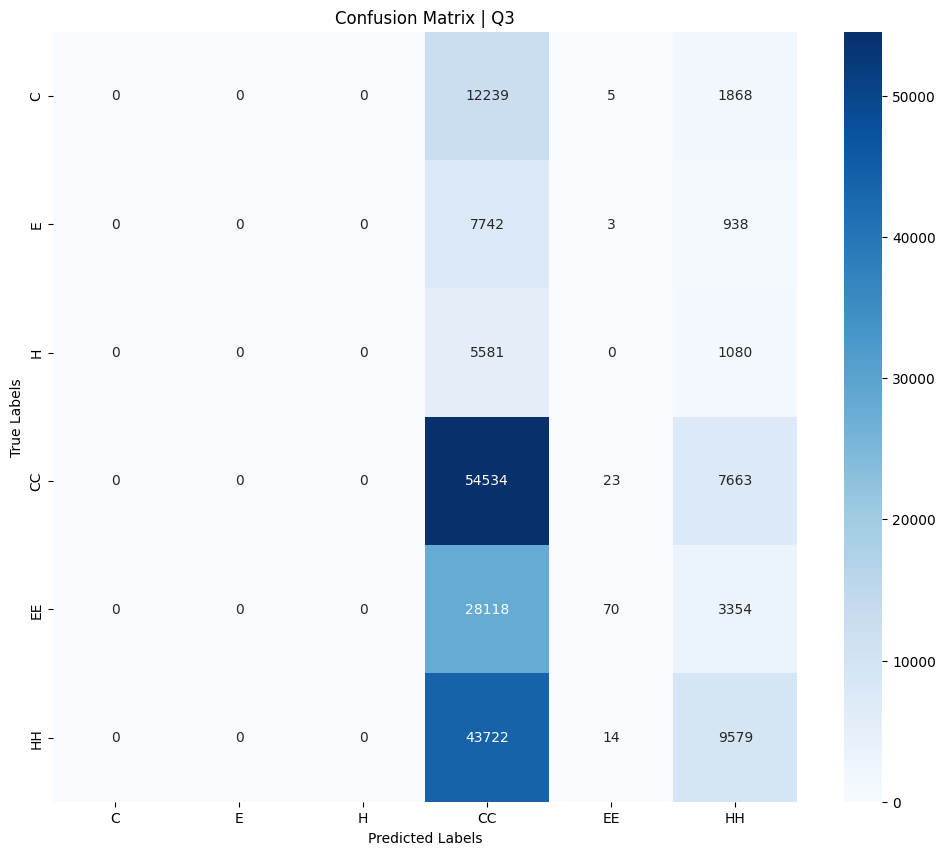

In [ ]:
# Training and Evaluation for Q3 and Q8

# Function to Split Data into Training and Validation Sets
def split_data(X, Y, validation_split=0.15):
    """Splits data into training and validation sets."""
    total_samples = X.shape[0]
    val_size = int(total_samples * validation_split)
    indices = torch.randperm(total_samples)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_val = X[val_indices]
    Y_val = Y[val_indices]

    return X_train, Y_train, X_val, Y_val

# Training and Evaluation for Q3

# Splitting Data
x_tr_q3, y_tr_q3, x_val_q3, y_val_q3 = split_data(X, Y_q3, validation_split=0.15)

# Preparing Inputs for Q3
data_q3 = {'x_train': x_tr_q3, 'y_train': y_tr_q3, 'x_val': x_val_q3, 'y_val': y_val_q3}
hyperparams = {
    'batch_size': 256,
    'epochs': 25,
    'lr': 3e-3,
    'eval_int': 1,
    'patience': 5,
    'factor': 0.1,
    'min_delta': 0.05,
    'b1': 0.9,
    'b2': 0.999
}

# Instantiate Model for Q3
pr_q3 = ProteinCNN(q3_vocab_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout)
pr_q3.to(device)
print(f"Q3 Model's trainable parameters: {sum(p.numel() for p in pr_q3.parameters())}")

# Instantiate Training Class for Q3
tr_q3 = Training(data_q3, pr_q3, hyperparams, q3_stoi, verbose=True)

# Train Q3 Model
tr_q3()

# Plot Learning Curves for Q3
plot_learning_curves(tr_q3, filename_prefix='q3_optimized')

# Plot Confusion Matrix for Q3
plot_confusion_matrix(pr_q3, tr_q3, q3_itos, q3_stoi, title='Confusion Matrix | Q3', filename='confusion_matrix_q3.png')


#### Q8

Q8 Model's trainable parameters: 209171
Epoch 1/25 | Train Loss: 2.2607 | Train Acc: 0.2472 | Train Precision: 0.3959 | Train F1: 0.1485
Validation Loss: 2.1667 | Validation Acc: 0.2727 | Validation Precision: 0.7195 | Validation F1: 0.1430
Epoch 2/25 | Train Loss: 2.1563 | Train Acc: 0.2776 | Train Precision: 0.5990 | Train F1: 0.1475
Validation Loss: 2.1568 | Validation Acc: 0.2771 | Validation Precision: 0.6162 | Validation F1: 0.1464
Epoch 3/25 | Train Loss: 2.1510 | Train Acc: 0.2790 | Train Precision: 0.6053 | Train F1: 0.1615
Validation Loss: 2.1546 | Validation Acc: 0.2776 | Validation Precision: 0.6172 | Validation F1: 0.1474
Epoch 4/25 | Train Loss: 2.1478 | Train Acc: 0.2807 | Train Precision: 0.6066 | Train F1: 0.1681
Validation Loss: 2.1503 | Validation Acc: 0.2804 | Validation Precision: 0.6066 | Validation F1: 0.1788
Epoch 5/25 | Train Loss: 2.1452 | Train Acc: 0.2820 | Train Precision: 0.6099 | Train F1: 0.1758
Validation Loss: 2.1502 | Validation Acc: 0.2809 | Validati

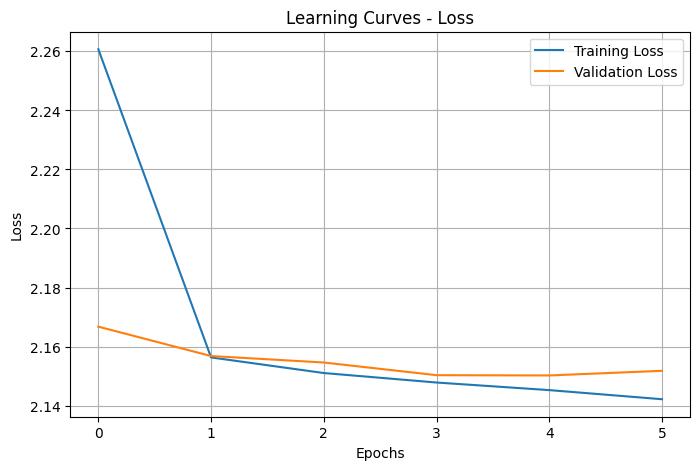

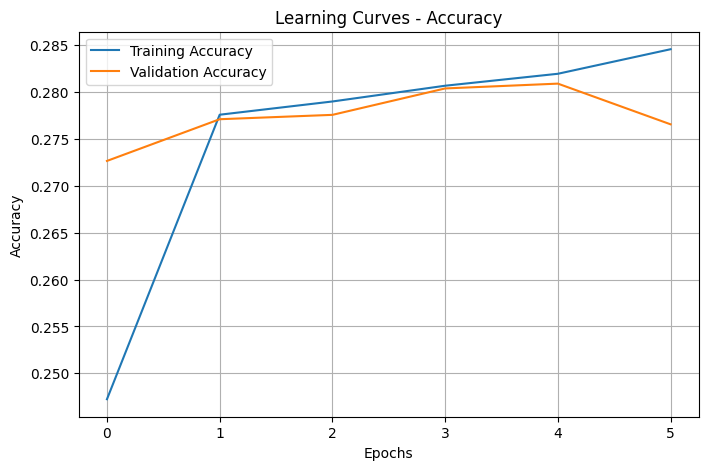

Valid labels after filtering: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


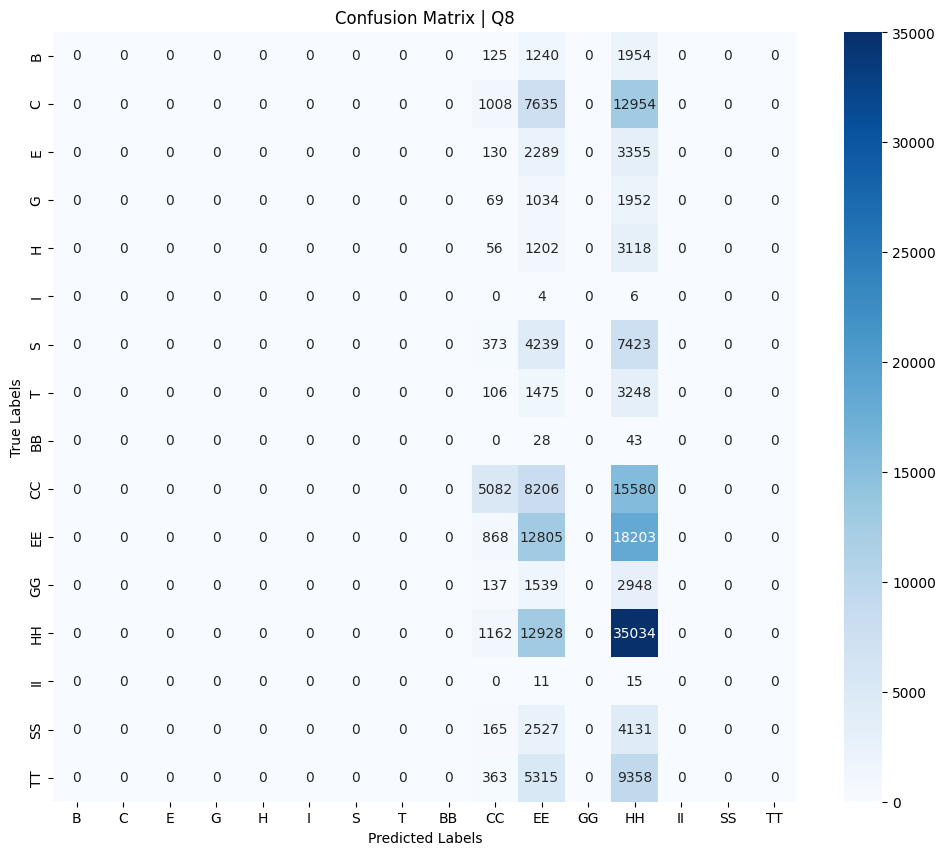

In [ ]:
# Splitting Data
x_tr_q8, y_tr_q8, x_val_q8, y_val_q8 = split_data(X, Y_q8, validation_split=0.15)

# Preparing Inputs for Q8
data_q8 = {'x_train': x_tr_q8, 'y_train': y_tr_q8, 'x_val': x_val_q8, 'y_val': y_val_q8}
# Reuse hyperparams or define new ones if needed

# Instantiate Model for Q8
pr_q8 = ProteinCNN(q8_vocab_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout)
pr_q8.to(device)
print(f"Q8 Model's trainable parameters: {sum(p.numel() for p in pr_q8.parameters())}")

# Instantiate Training Class for Q8
tr_q8 = Training(data_q8, pr_q8, hyperparams, q8_stoi, verbose=True)

# Train Q8 Model
tr_q8()

# Plot Learning Curves for Q8
plot_learning_curves(tr_q8, filename_prefix='q8_optimized')

# Plot Confusion Matrix for Q8
plot_confusion_matrix(pr_q8, tr_q8, q8_itos, q8_stoi, title='Confusion Matrix | Q8', filename='confusion_matrix_q8.png')



# Hyperparameter Tuning

## Hyperparameter Tuning w/ Bayesian Optmization

In [ ]:
# K-Fold CV Splitting

datasets = {'train': [], 'val': []}
k = KFold(n_splits=3, shuffle=True, random_state=42)
for tr, vl in k.split(np.array([i for i in range(X.shape[0])])):
    tr = torch.tensor(tr, dtype=torch.int, device=device)
    vl = torch.tensor(vl, dtype=torch.int, device=device)
    datasets['train'].append(tr)
    datasets['val'].append(vl)



In [ ]:
# Bayesian Optimization Hyperparameter Bounds

pbounds = {
    'lr': (1e-5, 0.1),
    'batch_size': (32, 256),
    'n_emb': (4, 256),
    'num_filters': (16, 256),
    'kernel_size': (3, 9),
    'num_conv_layers': (1, 5),
    'dropout': (0.0, 0.5),
    'patience': (1, 5),
    'factor': (0.1, 0.5),
    'min_delta': (0.01, 0.1),
    'b1': (0.9, 0.999),
    'b2': (0.95, 0.9999)
}

# Bayesian Optimization Parameters

init_p = 10
n_iter = 5

#### Q3

In [ ]:

def bayes_opt_func(lr, batch_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout, patience, factor, min_delta, b1, b2):
    n_emb = int(n_emb)
    num_filters = int(num_filters)
    kernel_size = int(kernel_size)
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure kernel_size is odd
    num_conv_layers = int(num_conv_layers)
    batch_size = int(batch_size)
    patience = int(patience)
    f1s = []
    for i in range(len(datasets['train'])):
        model = ProteinCNN(q3_vocab_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout)
        model.to(device)
        data = {
            'x_train': X[datasets['train'][i], :],
            'y_train': Y_q3[datasets['train'][i], :],
            'x_val': X[datasets['val'][i], :],
            'y_val': Y_q3[datasets['val'][i], :]
        }
        hyperparams = {
            'batch_size': batch_size,
            'epochs': 10,
            'lr': lr,
            'eval_int': eval_interval,
            'patience': patience,
            'factor': factor,
            'min_delta': min_delta,
            'b1': b1,
            'b2': b2
        }
        trainer = Training(data, model, hyperparams, q3_stoi, verbose=False)
        trainer()
        f1s.append(trainer.hist_f1['val'][-1])
    return np.mean(f1s)

# Bayesian Optimization for Q3

optimizer_q3 = BayesianOptimization(
    f=bayes_opt_func,
    pbounds=pbounds,
    random_state=seed,
)

optimizer_q3.maximize(
    init_points=init_p,
    n_iter=n_iter,
)

|   iter    |  target   |    b1     |    b2     | batch_... |  dropout  |  factor   | kernel... |    lr     | min_delta |   n_emb   | num_co... | num_fi... | patience  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.2134    | 0.9764    | 0.951     | 173.9     | 0.3744    | 0.2994    | 4.349     | 0.01981   | 0.07845   | 46.62     | 1.353     | 180.5     | 4.814     |
| 2         | 0.1817    | 0.9004    | 0.9756    | 214.0     | 0.3063    | 0.3887    | 4.751     | 0.09178   | 0.07431   | 140.7     | 1.569     | 105.6     | 3.697     |
| 3         | 0.1817    | 0.9437    | 0.9717    | 170.4     | 0.2566    | 0.3602    | 6.606     | 0.08052   | 0.05695   | 233.0     | 2.277     | 37.71     | 2.203     |
| 4         | 0.1817    | 0.9113    | 0.9914    | 42.5      | 0.3131    | 0.319     | 7.916     | 0.0199    | 0.08712   | 92.62     | 4.019     | 87.0

#### Q8

In [ ]:
def bayes_opt_func_q8(lr, batch_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout, patience, factor, min_delta, b1, b2):
    n_emb = int(n_emb)
    num_filters = int(num_filters)
    kernel_size = int(kernel_size)
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure kernel_size is odd
    num_conv_layers = int(num_conv_layers)
    batch_size = int(batch_size)
    patience = int(patience)
    f1s = []
    for i in range(len(datasets['train'])):
        model = ProteinCNN(q8_vocab_size, n_emb, num_filters, kernel_size, num_conv_layers, dropout)
        model.to(device)
        data = {
            'x_train': X[datasets['train'][i], :],
            'y_train': Y_q8[datasets['train'][i], :],
            'x_val': X[datasets['val'][i], :],
            'y_val': Y_q8[datasets['val'][i], :]
        }
        hyperparams = {
            'batch_size': batch_size,
            'epochs': 10,
            'lr': lr,
            'eval_int': eval_interval,
            'patience': patience,
            'factor': factor,
            'min_delta': min_delta,
            'b1': b1,
            'b2': b2
        }
        trainer = Training(data, model, hyperparams, q8_stoi, verbose=False)
        trainer()
        f1s.append(trainer.hist_f1['val'][-1])
    return np.mean(f1s)

# Bayesian Optimization for Q8

optimizer_q8 = BayesianOptimization(
    f=bayes_opt_func_q8,
    pbounds=pbounds,
    random_state=seed,
)

optimizer_q8.maximize(
    init_points=init_p,
    n_iter=n_iter,
)

|   iter    |  target   |    b1     |    b2     | batch_... |  dropout  |  factor   | kernel... |    lr     | min_delta |   n_emb   | num_co... | num_fi... | patience  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.1369    | 0.9764    | 0.951     | 173.9     | 0.3744    | 0.2994    | 4.349     | 0.01981   | 0.07845   | 46.62     | 1.353     | 180.5     | 4.814     |
| 2         | 0.1112    | 0.9004    | 0.9756    | 214.0     | 0.3063    | 0.3887    | 4.751     | 0.09178   | 0.07431   | 140.7     | 1.569     | 105.6     | 3.697     |
| 3         | 0.1064    | 0.9437    | 0.9717    | 170.4     | 0.2566    | 0.3602    | 6.606     | 0.08052   | 0.05695   | 233.0     | 2.277     | 37.71     | 2.203     |
| 4         | 0.1422    | 0.9113    | 0.9914    | 42.5      | 0.3131    | 0.319     | 7.916     | 0.0199    | 0.08712   | 92.62     | 4.019     | 87.0

In [ ]:
import json

best_params_q3 = optimizer_q3.max['params']

# Define the path to save the best parameters JSON file
params_json_path = '/content/drive/My Drive/Neural Networks Project/CNN_Equipair_Updated/optimized_q3_params.json'

# Convert float values to a JSON-compatible format and save
best_params_q3_json = {k: (int(v) if isinstance(v, float) and v.is_integer() else v) for k, v in best_params_q3.items()}

# Save the parameters as a JSON file
with open(params_json_path, 'w') as json_file:
    json.dump(best_params_q3_json, json_file, indent=4)

print(f"Best parameters saved as JSON at {params_json_path}")


Best parameters saved as JSON at /content/drive/My Drive/Neural Networks Project/CNN_Equipair_Updated/optimized_q3_params.json


In [ ]:
# Extract and save the best parameters for Q8
best_params_q8 = optimizer_q8.max['params']

# Define the path to save the best parameters JSON file for Q8
params_json_path_q8 = '/content/drive/My Drive/Neural Networks Project/CNN_Equipair_Updated/optimized_q8_params.json'

# Convert float values to JSON-compatible format
best_params_q8_json = {k: (int(v) if isinstance(v, float) and v.is_integer() else v) for k, v in best_params_q8.items()}

# Save the Q8 parameters as a JSON file
with open(params_json_path_q8, 'w') as json_file:
    json.dump(best_params_q8_json, json_file, indent=4)

print(f"Best parameters for Q8 saved as JSON at {params_json_path_q8}")


Best parameters for Q8 saved as JSON at /content/drive/My Drive/Neural Networks Project/CNN_Equipair_Updated/optimized_q8_params.json


## Model w/ Optimized Hyperparams

#### Q3

In [ ]:
import json

# Load the best parameters for Q3 from the JSON file
params_json_path_q3 = '/content/drive/My Drive/Neural Networks Project/CNN_Equipair_Updated/optimized_q3_params.json'
with open(params_json_path_q3, 'r') as json_file:
    best_params_q3 = json.load(json_file)

# Update the `hy` dictionary with the loaded optimized hyperparameters
hy = {
    'batch_size': int(best_params_q3['batch_size']),
    'epochs': 15,  # You can set this to any desired number of epochs
    'lr': best_params_q3['lr'],
    'eval_int': eval_interval,
    'patience': int(best_params_q3['patience']),
    'factor': best_params_q3['factor'],
    'min_delta': best_params_q3['min_delta'],
    'b1': best_params_q3['b1'],
    'b2': best_params_q3['b2']
}

# Instantiate the model using the optimized hyperparameters for model-specific configurations
pr = ProteinCNN(
    q3_vocab_size,
    n_emb=int(best_params_q3['n_emb']),
    num_filters=int(best_params_q3['num_filters']),
    kernel_size=int(best_params_q3['kernel_size']),
    num_conv_layers=int(best_params_q3['num_conv_layers']),
    dropout=best_params_q3['dropout']
)

# Move the model to the specified device
pr.to(device)
print(f"Model's trainable parameters: {sum(p.numel() for p in pr.parameters())}")

# Prepare the input data
data = {'x_train': X, 'y_train': Y_q3, 'x_val': X, 'y_val': Y_q3}

# Initialize and run the training loop
tr = Training(data, pr, hy, q3_stoi, verbose=True)
tr()

# Save the trained model to Google Drive
torch.save(pr.state_dict(), os.path.join(output_dir, 'Q3_protein_cnn_Equipair_optimized.pth'))
print("Model saved successfully with optimized hyperparameters.")


Model's trainable parameters: 24237
Epoch 1/15 | Train Loss: 1.5292 | Train Acc: 0.3429 | Train Precision: 0.2656 | Train F1: 0.2631
Validation Loss: 1.4981 | Validation Acc: 0.3579 | Validation Precision: 0.5762 | Validation F1: 0.1820
Epoch 2/15 | Train Loss: 1.5062 | Train Acc: 0.3487 | Train Precision: 0.3907 | Train F1: 0.2591
Validation Loss: 1.4969 | Validation Acc: 0.3613 | Validation Precision: 0.5736 | Validation F1: 0.2586
Epoch 3/15 | Train Loss: 1.5046 | Train Acc: 0.3501 | Train Precision: 0.4772 | Train F1: 0.2560
Validation Loss: 1.4974 | Validation Acc: 0.3582 | Validation Precision: 0.5814 | Validation F1: 0.1845
Early stopping triggered.
Model saved successfully with optimized hyperparameters.


In [ ]:
from IPython.display import display, HTML

# Adjusted decoder function
def adjusted_decoder(s, itos):
    decoded = []
    for c in s:
        val = itos[c]
        if isinstance(val, tuple):
            decoded.extend(val)
        else:
            decoded.append(val)
    return decoded

# Load the saved weights for Q3
state_dict_path_q3 = os.path.join(output_dir, 'Q3_protein_cnn_Equipair_optimized.pth')
state_dict_q3 = torch.load(state_dict_path_q3)
pr.load_state_dict(state_dict_q3, strict=True)
pr.eval()
print("Q3 Model loaded successfully.")

print(q3_stoi, '\n\n')
count = 0
acc_total = 0
errors = []

def predict_sequence(model, seq, seq_encoder, itos, stoi, max_len):
    # Preprocess the sequence
    seq = seq.strip()
    seq_padded = f"<{seq[:max_len]}>"
    if len(seq) < max_len:
        seq_padded += '.' * (max_len - len(seq))

    encoded_seq = seq_encoder(seq_padded)
    input_tensor = torch.tensor(encoded_seq, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        preds = torch.argmax(logits, dim=-1).squeeze(0).cpu().numpy()

    indices_to_ignore = [stoi.get('.', -1), stoi.get('<', -1), stoi.get('>', -1)]
    valid_positions = [i for i, idx in enumerate(encoded_seq) if idx not in indices_to_ignore]
    preds_valid = preds[valid_positions]
    decoded_preds = adjusted_decoder(preds_valid, itos)
    return ''.join(decoded_preds)

for i in range(df_test.shape[0]):
    count += 1
    seq = df_test['seq'][i]
    ground_truth = df_test['sst3'][i]
    pred = predict_sequence(pr, seq, seq_encoder, q3_itos, q3_stoi, max_len)
    pred = pred[:len(ground_truth)]

    # Calculate accuracy and record errors
    acc = [1 if p == g else 0 for p, g in zip(pred, ground_truth)]
    acc_perc = sum(acc) / len(acc)
    acc_total += acc_perc

    if acc_perc < 1:  # Save errors for display
        errors.append((seq, ground_truth, pred))

# Display errors with HTML highlighting
for seq, true_seq, pred_seq in errors[:10]:  # limit to 10 examples
    true_label_str = ''.join(true_seq)
    pred_label_str = ''
    for t, p in zip(true_seq, pred_seq):
        pred_label_str += f"<span style='color:red;'>{p}</span>" if t != p else p

    display(HTML(f"<strong>Sequence:</strong> {seq}"))
    display(HTML(f"<strong>True Label:</strong> {true_label_str}<br><strong>Predicted Label:</strong> {pred_label_str}"))
    display(HTML('<hr>'))

print(f'Average Accuracy for Q3: {acc_total / count}')


Q3 Model loaded successfully.
{'.': 0, '<': 1, '>': 2, 'C': 3, 'E': 4, 'H': 5, ('C', 'C'): 6, ('E', 'E'): 7, ('H', 'H'): 8} 




<ipython-input-38-ea5bf493882d>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_q3 = torch.load(state_dict_path_q3)


Average Accuracy for Q3: 0.4097672371852202


#### Q8

In [ ]:
import json
import os
import torch

# Load the best parameters for Q8 from the JSON file
params_json_path_q8 = '/content/drive/My Drive/Neural Networks Project/CNN_Equipair_Updated/optimized_q8_params.json'
with open(params_json_path_q8, 'r') as json_file:
    best_params_q8 = json.load(json_file)

# Update the `hy` dictionary with the loaded optimized hyperparameters for Q8
hy = {
    'batch_size': int(best_params_q8['batch_size']),
    'epochs': 15,  # Set to the desired number of epochs
    'lr': best_params_q8['lr'],
    'eval_int': eval_interval,
    'patience': int(best_params_q8['patience']),
    'factor': best_params_q8['factor'],
    'min_delta': best_params_q8['min_delta'],
    'b1': best_params_q8['b1'],
    'b2': best_params_q8['b2']
}

# Instantiate the model using the optimized hyperparameters for Q8 model-specific configurations
pr = ProteinCNN(
    q8_vocab_size,
    n_emb=int(best_params_q8['n_emb']),
    num_filters=int(best_params_q8['num_filters']),
    kernel_size=int(best_params_q8['kernel_size']),
    num_conv_layers=int(best_params_q8['num_conv_layers']),
    dropout=best_params_q8['dropout']
)

# Move the model to the specified device
pr.to(device)
print(f"Model's trainable parameters: {sum(p.numel() for p in pr.parameters())}")

# Prepare the input data for Q8
data = {'x_train': X, 'y_train': Y_q8, 'x_val': X, 'y_val': Y_q8}

# Initialize and run the training loop
tr = Training(data, pr, hy, q8_stoi, verbose=True)
tr()

# Save the trained model to Google Drive
torch.save(pr.state_dict(), os.path.join(output_dir, 'Q8_protein_cnn_Equipair_optimized.pth'))
print("Model saved successfully with optimized hyperparameters for Q8.")


Model's trainable parameters: 219205
Epoch 1/15 | Train Loss: 4.1304 | Train Acc: 0.2532 | Train Precision: 0.2119 | Train F1: 0.1541
Validation Loss: 2.1465 | Validation Acc: 0.2813 | Validation Precision: 0.6205 | Validation F1: 0.1412
Epoch 2/15 | Train Loss: 2.1669 | Train Acc: 0.2751 | Train Precision: 0.3474 | Train F1: 0.1402
Validation Loss: 2.1438 | Validation Acc: 0.2821 | Validation Precision: 0.6003 | Validation F1: 0.1407
Epoch 3/15 | Train Loss: 2.1629 | Train Acc: 0.2767 | Train Precision: 0.3638 | Train F1: 0.1426
Validation Loss: 2.1446 | Validation Acc: 0.2817 | Validation Precision: 0.5952 | Validation F1: 0.1415
Epoch 4/15 | Train Loss: 2.1629 | Train Acc: 0.2762 | Train Precision: 0.3617 | Train F1: 0.1422
Validation Loss: 2.1449 | Validation Acc: 0.2804 | Validation Precision: 0.7649 | Validation F1: 0.1402
Epoch 5/15 | Train Loss: 2.1637 | Train Acc: 0.2762 | Train Precision: 0.3238 | Train F1: 0.1429
Validation Loss: 2.1427 | Validation Acc: 0.2843 | Validation 

In [ ]:
from IPython.display import display, HTML

# Adjusted decoder function for Q8
def adjusted_decoder(s, itos):
    decoded = []
    for c in s:
        val = itos[c]
        if isinstance(val, tuple):
            decoded.extend(val)
        else:
            decoded.append(val)
    return decoded

# Load the saved weights for Q8
state_dict_path_q8 = os.path.join(output_dir, 'Q8_protein_cnn_Equipair_optimized.pth')
state_dict_q8 = torch.load(state_dict_path_q8)
pr.load_state_dict(state_dict_q8, strict=True)
pr.eval()
print("Q8 Model loaded successfully.")

print(q8_stoi, '\n\n')
count = 0
acc_total = 0
errors = []

def predict_sequence_q8(model, seq, seq_encoder, itos, stoi, max_len):
    # Preprocess the sequence
    seq = seq.strip()
    seq_padded = f"<{seq[:max_len]}>"
    if len(seq) < max_len:
        seq_padded += '.' * (max_len - len(seq))

    encoded_seq = seq_encoder(seq_padded)
    input_tensor = torch.tensor(encoded_seq, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        preds = torch.argmax(logits, dim=-1).squeeze(0).cpu().numpy()

    indices_to_ignore = [stoi.get('.', -1), stoi.get('<', -1), stoi.get('>', -1)]
    valid_positions = [i for i, idx in enumerate(encoded_seq) if idx not in indices_to_ignore]
    preds_valid = preds[valid_positions]
    decoded_preds = adjusted_decoder(preds_valid, itos)
    return ''.join(decoded_preds)

# Use Q8-specific data
for i in range(df_test.shape[0]):
    count += 1
    seq = df_test['seq'][i]
    ground_truth = df_test['sst8'][i]
    pred = predict_sequence_q8(pr, seq, seq_encoder, q8_itos, q8_stoi, max_len)
    pred = pred[:len(ground_truth)]

    # Calculate accuracy and record errors
    acc = [1 if p == g else 0 for p, g in zip(pred, ground_truth)]
    acc_perc = sum(acc) / len(acc)
    acc_total += acc_perc

    if acc_perc < 1:  # Save errors for display
        errors.append((seq, ground_truth, pred))

# Display errors with HTML highlighting
for seq, true_seq, pred_seq in errors[:10]:  # limit to 10 examples
    true_label_str = ''.join(true_seq)
    pred_label_str = ''
    for t, p in zip(true_seq, pred_seq):
        pred_label_str += f"<span style='color:red;'>{p}</span>" if t != p else p

    display(HTML(f"<strong>Sequence:</strong> {seq}"))
    display(HTML(f"<strong>True Label:</strong> {true_label_str}<br><strong>Predicted Label:</strong> {pred_label_str}"))
    display(HTML('<hr>'))

print(f'Average Accuracy for Q8: {acc_total / count}')


<ipython-input-43-d9b94cc1cc06>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_q8 = torch.load(state_dict_path_q8)


Q8 Model loaded successfully.
{'.': 0, '<': 1, '>': 2, 'B': 3, 'C': 4, 'E': 5, 'G': 6, 'H': 7, 'I': 8, 'S': 9, 'T': 10, ('B', 'B'): 11, ('C', 'C'): 12, ('E', 'E'): 13, ('G', 'G'): 14, ('H', 'H'): 15, ('I', 'I'): 16, ('S', 'S'): 17, ('T', 'T'): 18} 




Average Accuracy for Q8: 0.36394807750727454
